<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/mosaic_encoder_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Tue Mar 30 21:50:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mosaic encoder
#### Qian Huang
#### Mar 30

Following the thought of "demo_image_feature_representation.ipynb", encoder on the measurement end is mainly to compress the data. The encoder should be generic and light so that it can be deployed on the camera head with ease. I feel we can start with DLACS module and see if it can be plugged in the current pipeline.

#### Pipeline from the notebook mentioned above:

camera sensor data -> (preprocessing, like alignment) -> **measurement encoder** (compress data) -> measurement features -> **measurement decoder** -> estimation features -> **specific estimation decoder** -> specific estimation

### DLACS compression demo

In [2]:
# ! unzip -q /content/drive/MyDrive/blender_512.zip -d scenes/

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import h5py
import cv2

def print_stat(narray, narray_name = "Array"):
    print(narray_name, "shape: ", narray.shape, "dtype:", narray.dtype)
    arr = narray.flatten()
    print(narray_name , "stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

def load_exr(path):
        img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

In [4]:
def show_data(x_in, pre_in):
    mean = np.mean(x_in)
    std = np.std(x_in)
    Max = np.max(x_in)
    Min = np.min(x_in)
    dtype = x_in.dtype

    print(pre_in + ' shape: ' + str(x_in.shape) + ' , type: ' + str(dtype) + ' , mean = ' + str(mean)
          + ' , std = ' + str(std) + ' , Max = ' + str(Max) + ' , Min = ' + str(Min))

In [5]:
Nx=2048
Ny=3840
NC = 1

bit_proc = 10 #bit depth for operation

block_size = 8
stride_size = 8
ncomp = 1

Nchans = 3

Q_scales = {}
Q_scales[0] = 1/4.
Q_scales[1] = -1/4.
Q_scales[2] = -1/8.

codes = {}
for i_c in range(Nchans):
    fname = 'code_881_chan_%d.h5'%(i_c)
    print('\n' + fname)
    ftmp=h5py.File(fname,'r')
    tmp=ftmp['data'][:]
    codes[i_c] = tmp.astype(np.float32)
    show_data(codes[i_c],'codes[%d]'%(i_c))


code_881_chan_0.h5
codes[0] shape: (8, 8, 1, 1) , type: float32 , mean = 11.8125 , std = 30.038973 , Max = 127.0 , Min = -37.0

code_881_chan_1.h5
codes[1] shape: (8, 8, 1, 1) , type: float32 , mean = -12.328125 , std = 30.397396 , Max = 28.0 , Min = -126.0

code_881_chan_2.h5
codes[2] shape: (8, 8, 1, 1) , type: float32 , mean = -18.09375 , std = 45.037384 , Max = 71.0 , Min = -127.0


In [6]:
def mask_operation(data_tmp, code_1_chan,tmp_type=np.float64):
    cshape = code_1_chan.shape
    nx = int(data_tmp.shape[0]/cshape[0]); ny = int(data_tmp.shape[1]/cshape[1])
    comp1c = np.zeros([nx,ny],dtype=tmp_type)
    for ix in range(nx):
        xs = ix*cshape[0]; xe = xs+cshape[0]
        for iy in range(ny):
            ys = iy*cshape[1]; ye = ys+cshape[1]
            comp1c[ix,iy] = np.sum(data_tmp[xs:xe,ys:ye]*code_1_chan)
            
    return comp1c

def compression_Numpy(Data_in, codes_in, Q_scales_in, Q_type=np.uint8, tmp_type=np.float64):
    assert(len(codes_in)==len(Q_scales_in))
    cshape = codes_in[0].shape
    assert(Data_in.shape[0]%cshape[0]==0 and Data_in.shape[1]%cshape[1]==0)
    nx = int(Data_in.shape[0]/cshape[0]); ny = int(Data_in.shape[1]/cshape[1])
    
    comp = np.zeros([nx,ny,len(codes_in)],dtype=tmp_type)
    for i in range(len(codes_in)):
        comp[:,:,i] = mask_operation(Data_in, codes_in[i][:,:,0,0], tmp_type=tmp_type)
        comp[:,:,i] = comp[:,:,i]*Q_scales_in[i]
        
    # Quantization steps below. Actual hardware running can change tmp_type etc. for simplification
    comp = comp/(np.power(2,bit_proc))
    comp = np.floor(comp)
    comp = comp.astype(Q_type)
    return comp

In [24]:
import skimage.measure

class camMosaicModel:
    def __init__(self):
        ''' params that are from experiments on EVETAR camera '''
        self.sigma_r = 5.3e-4
        self.sigma_s = 8.9e-5
        self.bit_depth = 10
        self.black_level = 50
        ''' params that are NOT from experiments on EVETAR camera '''
        self.amplitude = 2 * 64 * 4

    def noise_model(self, img_gt):
        '''
        follow the noise model of signal-dependent normal distribution
        '''
        sigma_noise = np.sqrt(self.sigma_r**2 + self.sigma_s*img_gt)
        noise = np.random.randn(*img_gt.shape) * sigma_noise
        img_noisy = img_gt + noise
        return img_noisy

    def rgb2bayer(self, img):
        '''
        filter a full RGB frame to be a raw frame.
        '''
        h, w, c = img.shape
        bayer_img = np.zeros((h, w))
        bayer_img[::2, ::2] = img[::2, ::2, 0]
        bayer_img[1::2, 1::2] = img[::2, ::2, 2]
        bayer_img[::2, 1::2] = img[::2, 1::2, 1]
        bayer_img[1::2, ::2] = img[1::2, ::2, 1]
        return bayer_img

    def spatial_sampling(self, img, pix = 1):
        h, w, c = img.shape
        return skimage.measure.block_reduce(img, (pix,pix, 1), np.sum)

    
    def develop(self, img_gt):
        '''
        develop raw frame from ground truth via the noise model, quantization, CFA.
        '''
        img = self.spatial_sampling(img_gt)
        img_noisy = self.noise_model(img)
        sensor_noisy = np.clip(np.round(img_noisy * self.amplitude) + self.black_level,
                               0, 2**self.bit_depth)
        sensor_noisy_float = (sensor_noisy - self.black_level)/(2**self.bit_depth - self.black_level)
        bayer_noisy = self.rgb2bayer(sensor_noisy)
        bayer_noisy_float = self.rgb2bayer(sensor_noisy_float)
        return sensor_noisy.astype(np.uint16), sensor_noisy_float, bayer_noisy.astype(np.uint16), bayer_noisy_float

Array shape:  (512, 512, 3) dtype: float32
Array stat: max: 1.6806640625, min: 0.0293121337890625, mean: 0.6683080196380615, std: 0.3823400139808655
Dynamic range is 5.8 bits


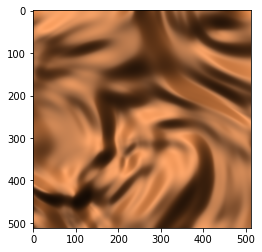

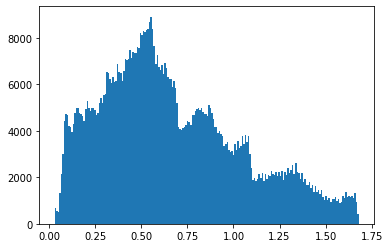

Array shape:  (512, 512) dtype: uint16
Array stat: max: 926, min: 64, mean: 387.3883972167969, std: 182.344403100619


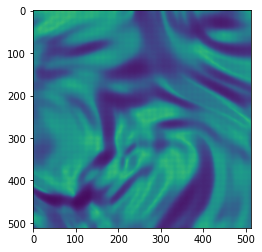

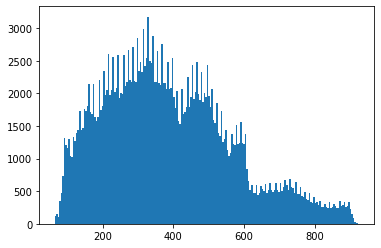

In [25]:
img = load_exr("scenes/scene0000/Image/Image0002.exr")
cam = camMosaicModel()
print_stat(img)
print("Dynamic range is {:.1f} bits".format(np.log2(img.max()/img.min())))
plt.imshow(img/img.max())
plt.show()
plt.hist(img.flatten(), bins=200)
plt.show()
sensor_noisy, sensor_noisy_float, bayer_noisy, bayer_noisy_float = cam.develop(img)
print_stat(bayer_noisy)
plt.imshow(bayer_noisy/bayer_noisy.max())
plt.show()
plt.hist(bayer_noisy.flatten(), bins=200)
plt.show()

In [27]:
comp_o = compression_Numpy(Data_in=bayer_noisy, codes_in=codes, Q_scales_in=Q_scales, Q_type=np.uint8, tmp_type=np.float64)

for i in range(Nchans):
    show_data(comp_o[:,:,i],'\ncomp_o[:,:,%d]'%(i))


comp_o[:,:,0] shape: (64, 64) , type: uint8 , mean = 97.865478515625 , std = 33.55229592998617 , Max = 159 , Min = 21

comp_o[:,:,1] shape: (64, 64) , type: uint8 , mean = 46.615234375 , std = 17.673882300447413 , Max = 79 , Min = 12

comp_o[:,:,2] shape: (64, 64) , type: uint8 , mean = 55.799072265625 , std = 19.754262028229096 , Max = 91 , Min = 13


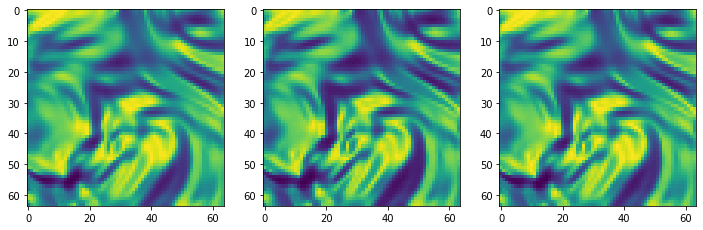

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].imshow(comp_o[:, :, 0])
ax[1].imshow(comp_o[:, :, 1])
ax[2].imshow(comp_o[:, :, 2])
plt.show()